In [ ]:
#!/usr/bin/python3
# Install TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers, activations
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt
# import autokeras as ak
import corner
import os 
import sys
import time
import importlib
import logging
from tqdm import tqdm

importlib.reload(logging)
logging.basicConfig(level = logging.INFO)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

logging.info("numpy Version is {}".format(np.__version__))
logging.info("tensorflow Version is {}".format(tf.keras.__version__))
logging.info("tensorflow_probability Version is {}".format(tfp.__version__))
logging.info("\n")

Ref: https://agustinus.kristia.de/techblog/2016/12/17/conditional-vae/   
Ref: https://keras.io/guides/customizing_what_happens_in_fit/   
Ref: https://keras.io/examples/generative/vae/   
Ref: https://github.com/hagabbar/VItamin/blob/c1ae6dfa27b8ab77193caacddd477fde0dece1c2/Models/VICI_inverse_model.py#L404   
Ref: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateNormalDiag    

In [84]:
def Gaussian(x, mean, var):
    SMALL_CONSTANT = 1e-12 
    var = var + SMALL_CONSTANT
    
    a = 1/np.sqrt(var)/np.sqrt(2*np.pi)
    
    b = np.exp(-1/2*(x-mean**2)**2/var)
    
    return a*b*50

In [85]:
%%time

N = int(1E+6)

x = np.linspace(-10,40,81)

mean = np.random.uniform(low=-np.sqrt(20.0), high=np.sqrt(20.0), size= N )
mean = np.reshape(mean, (len(mean),1))
var = np.random.uniform(low=1, high=10.0, size= N ) 
var = np.reshape(var, (len(var),1))

y = Gaussian(x, mean, var)

logging.info("mean.shape {}".format(mean.shape))
logging.info("var.shape {}".format(var.shape))
logging.info("x.shape {}".format(x.shape))
logging.info("y.shape {}".format(y.shape))

INFO:root:mean.shape (1000000, 1)
INFO:root:var.shape (1000000, 1)
INFO:root:x.shape (81,)
INFO:root:y.shape (1000000, 81)


CPU times: user 1.67 s, sys: 1.12 s, total: 2.79 s
Wall time: 2.79 s


In [86]:
%%time
"""
Standardization
"""
scaler = StandardScaler()
scaler.fit(y)

target = np.column_stack( [mean, var])

x_train = y[:int(len(y)/10*9)]
y_train = target[:int(len(y)/10*9)]


x_test = y[int(len(y)/10*9):]
y_test = target[int(len(y)/10*9):]

logging.info("X train shape: {}".format(x_train.shape))
logging.info("X test shape: {}".format(x_test.shape))
logging.info("Y train shape: {}".format(y_train.shape))
logging.info("Y test shape: {}".format(y_test.shape))

x_train_poisson = np.random.poisson(x_train)
# x_train_poisson = scaler.transform(x_train_poisson) 

x_test_poisson = np.random.poisson(x_test)
# x_test_poisson = scaler.transform(x_test_poisson) 

logging.info("\n")
logging.info("x_train_poisson shape: {}".format(x_train_poisson.shape))
logging.info("x_test_poisson shape: {}".format(x_test_poisson.shape))
logging.info("\n")

INFO:root:X train shape: (900000, 81)
INFO:root:X test shape: (100000, 81)
INFO:root:Y train shape: (900000, 2)
INFO:root:Y test shape: (100000, 2)
INFO:root:

INFO:root:x_train_poisson shape: (900000, 81)
INFO:root:x_test_poisson shape: (100000, 81)
INFO:root:



CPU times: user 4.09 s, sys: 1.3 s, total: 5.39 s
Wall time: 5.39 s


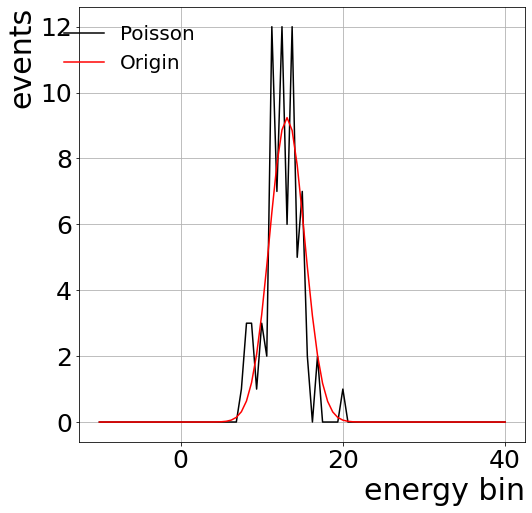

CPU times: user 129 ms, sys: 8.94 ms, total: 137 ms
Wall time: 135 ms


In [87]:
%%time

fig, ax = plt.subplots(1,1, figsize=(8,8))


# average = np.average(x_train_poisson[:,:],axis=0)
# p_yerr = np.max(x_train_poisson[:,:],axis=0)
# n_yerr = np.min(x_train_poisson[:,:],axis=0)
# # uncertainty = [n_yerr, p_yerr]

# plt.fill_between(x, n_yerr, p_yerr, alpha=0.5, label="Band")
# plt.plot(x, average, c="k", label="Average")

plt.plot(x, x_test_poisson[1], c="k", label="Poisson")
plt.plot(x, x_test[1], c="r", label="Origin")


ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlabel("energy bin", fontsize=30,horizontalalignment='right',x=1) 
plt.ylabel("events", fontsize=30, horizontalalignment='right',y=1)
plt.grid()
# plt.xlim((5,16))
# plt.ylim((0))
plt.legend(bbox_to_anchor=(0.3, 1),ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)

plt.show()

In [88]:
latent_dim = 10
mixture_dim = 40
logging.info("latent_dim : {}".format(latent_dim))
logging.info("mixture_dim : {}".format(mixture_dim))

"""
Encoder 1 (parameter + spectrum)
"""
# parameter
encoder_parameter_inputs = layers.Input(shape=(2,),name = 'encoder_parameter_inputs')
x_parameter = layers.Dense(64, activation="relu", name = 'dense_parameter_1')(encoder_parameter_inputs)
x_parameter = layers.Dense(32, activation="relu", name = 'dense_parameter_2')(x_parameter)
x_parameter = layers.Dense(16, activation="relu", name = 'dense_parameter_3')(x_parameter)

# spectrum
encoder_spectrum_inputs = layers.Input(shape=(y.shape[1],),name = 'encoder_spectrum_inputs')
x_spectrum = layers.Dense(64, activation="relu", name = 'dense_spectrum_1')(encoder_spectrum_inputs)
x_spectrum = layers.Dense(32, activation="relu", name = 'dense_spectrum_2')(x_spectrum)
x_spectrum = layers.Dense(16, activation="relu", name = 'dense_spectrum_3')(x_spectrum)


# merged
mergedOut_Encoder_1 = Concatenate()([x_parameter,x_spectrum])


z_mean = layers.Dense(latent_dim, name="z_mean")(mergedOut_Encoder_1)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(mergedOut_Encoder_1)

# build model
encoder_1 = keras.Model([encoder_parameter_inputs, encoder_spectrum_inputs], [z_mean, z_log_var], name="encoder_1")
encoder_1.summary()

INFO:root:latent_dim : 10
INFO:root:mixture_dim : 40


Model: "encoder_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_parameter_inputs (Input [(None, 2)]          0                                            
__________________________________________________________________________________________________
encoder_spectrum_inputs (InputL [(None, 81)]         0                                            
__________________________________________________________________________________________________
dense_parameter_1 (Dense)       (None, 64)           192         encoder_parameter_inputs[0][0]   
__________________________________________________________________________________________________
dense_spectrum_1 (Dense)        (None, 64)           5248        encoder_spectrum_inputs[0][0]    
__________________________________________________________________________________________

In [89]:
"""
Encoder 2 (spectrum)
"""
# spectrum
encoder_spectrum_inputs = layers.Input(shape=(y.shape[1],),name = 'encoder_spectrum_inputs')
x_spectrum = layers.Dense(64, activation="relu", name = 'dense_spectrum_1')(encoder_spectrum_inputs)
x_spectrum = layers.Dense(32, activation="relu", name = 'dense_spectrum_2')(x_spectrum)
x_spectrum = layers.Dense(16, activation="relu", name = 'dense_spectrum_3')(x_spectrum)


# sampling
z_mean = layers.Dense(mixture_dim*latent_dim, name="z_mean")(x_spectrum)
z_log_var = layers.Dense(mixture_dim*latent_dim, name="z_log_var")(x_spectrum)
z_weight = layers.Dense(mixture_dim, name="z_weight")(x_spectrum)

# build model
encoder_2 = keras.Model(encoder_spectrum_inputs, [z_mean, z_log_var, z_weight], name="encoder_2")
encoder_2.summary()

Model: "encoder_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_spectrum_inputs (InputL [(None, 81)]         0                                            
__________________________________________________________________________________________________
dense_spectrum_1 (Dense)        (None, 64)           5248        encoder_spectrum_inputs[0][0]    
__________________________________________________________________________________________________
dense_spectrum_2 (Dense)        (None, 32)           2080        dense_spectrum_1[0][0]           
__________________________________________________________________________________________________
dense_spectrum_3 (Dense)        (None, 16)           528         dense_spectrum_2[0][0]           
__________________________________________________________________________________________

In [91]:
"""
Decoder Model (latent + spectrum)
"""
latent_dim_2 = 2

decoder_latent_inputs = keras.Input(shape=(latent_dim,),name = 'decoder_latent_inputs')
x_latent = layers.Dense(64, activation="relu", name = 'dense_1')(decoder_latent_inputs)
x_latent = layers.Dense(32, activation="relu", name = 'dense_2')(x_latent)
x_latent = layers.Dense(16, activation="relu", name = 'dense_3')(x_latent)


# spectrum
decoder_spectrum_inputs = layers.Input(shape=(y.shape[1],),name = 'decoder_spectrum_inputs')
x_spectrum = layers.Dense(64, activation="relu", name = 'dense_spectrum_1')(decoder_spectrum_inputs)
x_spectrum = layers.Dense(32, activation="relu", name = 'dense_spectrum_2')(x_spectrum)
x_spectrum = layers.Dense(16, activation="relu", name = 'dense_spectrum_3')(x_spectrum)

# merged
mergedOut_Decoder = Concatenate()([x_latent,x_spectrum])


z2_mean = layers.Dense(mixture_dim*latent_dim_2, name="z_mean")(mergedOut_Decoder)
z2_log_var = layers.Dense(mixture_dim*latent_dim_2, name="z_log_var")(mergedOut_Decoder)
z2_weight = layers.Dense(mixture_dim, name="z_weight")(x_spectrum)

decoder = keras.Model([decoder_latent_inputs, decoder_spectrum_inputs], [z2_mean, z2_log_var, z2_weight], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_latent_inputs (InputLay [(None, 10)]         0                                            
__________________________________________________________________________________________________
decoder_spectrum_inputs (InputL [(None, 81)]         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           704         decoder_latent_inputs[0][0]      
__________________________________________________________________________________________________
dense_spectrum_1 (Dense)        (None, 64)           5248        decoder_spectrum_inputs[0][0]    
____________________________________________________________________________________________

In [92]:
#Ref: https://keras.io/guides/customizing_what_happens_in_fit/
#Ref: https://keras.io/examples/generative/vae/
#Ref: https://github.com/hagabbar/VItamin/blob/c1ae6dfa27b8ab77193caacddd477fde0dece1c2/Models/VICI_inverse_model.py#L404
class CVAE(keras.Model):
    def __init__(self, encoder1, encoder2, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder1 = encoder1  #(parameter + spectrum)
        self.encoder2 = encoder2  #(spectrum)
        self.decoder = decoder    #(latent + spectrum)
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
                ]

    def train_step(self, data):
        x, y = data
        
        
        with tf.GradientTape() as tape:
            
            SMALL_CONSTANT = 1e-12 # necessary to prevent the division by zero in many operations 
            
            # encoder1: 
            # input: [parameter, spectrum]
            # output: [mean, log_var]
            # mean.shape= (N, 2)  log_var.shape= (N, 2)   D(latent space) = 2
            z1_mean, z1_log_var = self.encoder1(x)  #(parameter + spectrum)
            
            # GET q(z|x,y)   #(parameter + spectrum)
            temp_var_q = SMALL_CONSTANT + tf.exp(z1_log_var)
            mvn_q = tfp.distributions.MultivariateNormalDiag(
                          loc=z1_mean,
                          scale_diag=tf.sqrt(temp_var_q))
            
            z1 = mvn_q.sample()
            
            
            # encoder2: 
            # input: spectrum
            # output: [mean, log_var, weight]
            # mean.shape= (N, mixture_dim*latent_dim)  log_var.shape= (N, mixture_dim*latent_dim) weight.shape= (N, mixture_dim)  
            # D(latent space)=2, D(mixture component)=mixture_dim
            z2_mean, z2_log_var, z2_weight = self.encoder2(x[1])  #(spectrum)
            
            
            # mean->reshape= (N, mixture_dim, latent_dim)  log_var->reshape= (N, mixture_dim, latent_dim) for create mixture model
            z2_mean = tf.reshape(z2_mean, (-1, mixture_dim, latent_dim))
            z2_log_var = tf.reshape(z2_log_var, (-1, mixture_dim, latent_dim))
            z2_weight = tf.reshape(z2_weight, (-1, mixture_dim))
            
            # Get r1(z|y) mixture model   #(spectrum)
            temp_var_r1 = SMALL_CONSTANT + tf.exp(z2_log_var)
            bimix_gauss = tfp.distributions.MixtureSameFamily(
                          mixture_distribution=tfp.distributions.Categorical(logits=z2_weight),
                          components_distribution=tfp.distributions.MultivariateNormalDiag(
                          loc=z2_mean,
                          scale_diag=tf.sqrt(temp_var_r1)))
            
            z2 = bimix_gauss.sample()
            
            
            # decoder: 
            # input: [latent, spectrum]
            # output: [mean, log_var]
            # mean.shape= (N, 2)  log_var.shape= (N, 2) 
            reconstruction_mean, reconstruction_var, reconstruction_weight = self.decoder([z1, x[1]])      #(latent + spectrum)
            reconstruction_mean = tf.reshape(reconstruction_mean, (-1, mixture_dim, latent_dim_2))
            reconstruction_var = tf.reshape(reconstruction_var, (-1, mixture_dim, latent_dim_2))
            reconstruction_weight = tf.reshape(reconstruction_weight, (-1, mixture_dim))
            
            
#             # GET r2(x|z,y)    #(latent + spectrum)
#             temp_var_r2 = SMALL_CONSTANT + tf.exp(reconstruction_var)
#             reconstruction_parameter = tfp.distributions.MultivariateNormalDiag(
#                                      loc=reconstruction_mean,
#                                      scale_diag= tf.sqrt(temp_var_r2))
            
#             r2 = reconstruction_parameter.sample()

            temp_var_r2 = SMALL_CONSTANT + tf.exp(reconstruction_var)
            reconstruction_parameter = tfp.distributions.MixtureSameFamily(
                      mixture_distribution=tfp.distributions.Categorical(logits=reconstruction_weight),
                      components_distribution=tfp.distributions.MultivariateNormalDiag(
                      loc=reconstruction_mean,
                      scale_diag=tf.sqrt(temp_var_r2)))

            r2 = reconstruction_parameter.sample()
            

        
        
            log_q_q = mvn_q.log_prob(z1)
            log_r1_q = bimix_gauss.log_prob(z1)               # evaluate the log prob of r1 at the q samples(z1)
            kl_loss = tf.reduce_mean(log_q_q - log_r1_q)      # average over batch
            
            
            reconstruction_parameter_loss = reconstruction_parameter.log_prob(y)
            reconstruction_loss = -1.0*tf.reduce_mean(reconstruction_parameter_loss)
                                        
            total_loss = reconstruction_loss + kl_loss
            
            
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [93]:
"""
Model Training
"""
cvae = CVAE(encoder_1,encoder_2, decoder)
cvae.compile(optimizer=keras.optimizers.Adam())
# vae.compile(optimizer=keras.optimizers.Adadelta())

check_list=[]
csv_logger = CSVLogger("./Training_loss/CVAE_1DCNN_training_log_toytest.csv")
check_list.append(csv_logger)



In [94]:
%%time
cvae.fit( x = [y_train, x_train],
#          x = [y_train, x_train_poisson],
         y = y_train,
           batch_size=100,
           epochs=50,
           verbose=1,
#            callbacks=check_list,
         )

Epoch 1/50
9000/9000 [==============================] - 34s 4ms/step - loss: -1.5910 - reconstruction_loss: -2.7790 - kl_loss: 0.0046
Epoch 2/50
9000/9000 [==============================] - 32s 4ms/step - loss: -3.5182 - reconstruction_loss: -3.5451 - kl_loss: 8.4948e-04
Epoch 3/50
9000/9000 [==============================] - 32s 4ms/step - loss: -3.5924 - reconstruction_loss: -3.7181 - kl_loss: 8.7409e-04
Epoch 4/50
9000/9000 [==============================] - 32s 4ms/step - loss: -3.8222 - reconstruction_loss: -3.9352 - kl_loss: 8.4890e-04
Epoch 5/50
9000/9000 [==============================] - 32s 4ms/step - loss: -4.2228 - reconstruction_loss: -4.2199 - kl_loss: 8.2870e-04
Epoch 6/50
9000/9000 [==============================] - 32s 4ms/step - loss: -4.2252 - reconstruction_loss: -4.2060 - kl_loss: 8.4039e-04
Epoch 7/50
9000/9000 [==============================] - 32s 4ms/step - loss: -4.1019 - reconstruction_loss: -4.1920 - kl_loss: 8.7773e-04
Epoch 8/50
9000/9000 [================

In [ ]:
# import pandas as pd 

# fig, ax = plt.subplots(2,1, figsize=(8,16))

# training_log = pd.read_csv("./Training_loss/CVAE_1DCNN_training_log.csv")


# ax[0].plot(training_log.index+1, training_log["reconstruction_loss"], "-", color='g', label="reconstruction_loss")
# ax[0].plot(training_log.index+1, training_log["kl_loss"], "--", color='lightgreen', label="kl_loss")

# ax[0].set_yscale("log")

# ax[0].tick_params(axis='x', labelsize=25)
# ax[0].tick_params(axis='y', labelsize=25)

# ax[0].legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)

# ax[0].set_xlabel("Epoch", fontsize=30,horizontalalignment='right',x=1) 
# ax[0].set_ylabel("Loss ", fontsize=30, horizontalalignment='right',y=1)


# ax[1].plot(training_log.index+1, training_log["theta23_loss"], "-", color='g', label="theta23_loss")
# ax[1].plot(training_log.index+1, training_log["delta_loss"], "--", color='lightgreen', label="delta_loss")

# ax[1].set_yscale("log")

# ax[1].tick_params(axis='x', labelsize=25)
# ax[1].tick_params(axis='y', labelsize=25)

# ax[1].legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)

# ax[1].set_xlabel("Epoch", fontsize=30,horizontalalignment='right',x=1) 
# ax[1].set_ylabel("Loss ", fontsize=30, horizontalalignment='right',y=1)

# # ax[0].set_ylim((0,0.02))
# # ax[1].set_ylim((0,0.6))

# # ax[0].set_xlim((80, 140))
# # ax[1].set_xlim((80, 140))
# # plt.yscale("log")
# # # plt.xlim((5))
# # ax[0].set_ylim((0.015,0.035))
# # ax[1].set_xlabel("Epoch", fontsize=30,horizontalalignment='right',x=1) 
# # ax[1].set_ylabel("Val Loss ", fontsize=30, horizontalalignment='right',y=1)
# # # plt.grid()

# # ax[1].legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
 

# plt.show()

In [ ]:
# cvae.encoder1.save("./Model/CVAE_1DCNN_encoder_1_test_v2.h5")
# cvae.encoder2.save("./Model/CVAE_1DCNN_encoder_2_test_v2.h5")
# cvae.decoder.save("./Model/CVAE_1DCNN_decoder_test_v2.h5")

In [95]:
# cvae_encoder = load_model("./Model/CVAE_1DCNN_encoder_2_v2_2.h5", compile=False)
# cvae_decoder = load_model("./Model/CVAE_1DCNN_decoder_v2_2.h5", compile=False)


cvae_encoder = encoder_2
cvae_decoder = decoder

In [96]:

test_index = 2
true_mean = y_test[test_index-1:test_index,0]
true_var = y_test[test_index-1:test_index,1]
logging.info("Ture: mean {}, var {} ".format(true_mean,true_var))

INFO:root:Ture: mean [3.62180258], var [4.66048621] 


In [99]:
%%time
#CVAE

test_index = 2

# data_normal_array = x_test_poisson[test_index-1:test_index]
data_normal_array = x_test[test_index-1:test_index]
true_mean = y_test[test_index-1:test_index,0]
true_var = y_test[test_index-1:test_index,1]

logging.info(data_normal_array.shape)

mean, log_var, weight = cvae_encoder.predict(data_normal_array)
# logging.info(mean.shape,log_var.shape,weight.shape)
mean = tf.reshape(mean, (-1, mixture_dim, latent_dim))
log_var = tf.reshape(log_var, (-1, mixture_dim, latent_dim))
weight = tf.reshape(weight, (-1, mixture_dim))
# logging.info(mean.shape,log_var.shape,weight.shape)

SMALL_CONSTANT = 1e-12
temp_var = SMALL_CONSTANT + tf.exp(log_var)
test_sampling = tfp.distributions.MixtureSameFamily(
              mixture_distribution=tfp.distributions.Categorical(logits=weight),
              components_distribution=tfp.distributions.MultivariateNormalDiag(
              loc=mean,
              scale_diag=tf.sqrt(temp_var)))



n_test= int(1E+4)
prediction = []
for i in range(n_test):
    Z3 = test_sampling.sample()
    
    
    reconstruction_mean, reconstruction_var, reconstruction_weight = cvae_decoder.predict([Z3, data_normal_array])      #(latent + spectrum)
    reconstruction_mean = tf.reshape(reconstruction_mean, (-1, mixture_dim, latent_dim_2))
    reconstruction_var = tf.reshape(reconstruction_var, (-1, mixture_dim, latent_dim_2))
    reconstruction_weight = tf.reshape(reconstruction_weight, (-1, mixture_dim))

    temp_var = SMALL_CONSTANT + tf.exp(reconstruction_var)
    reconstruction_parameter = tfp.distributions.MixtureSameFamily(
              mixture_distribution=tfp.distributions.Categorical(logits=reconstruction_weight),
              components_distribution=tfp.distributions.MultivariateNormalDiag(
              loc=reconstruction_mean,
              scale_diag=tf.sqrt(temp_var)))
        
#     reconstruction_mean, reconstruction_var = cvae_decoder.predict([Z3, data_normal_array])
#     temp_var = SMALL_CONSTANT + tf.exp(reconstruction_var)
#     reconstruction_parameter = tfp.distributions.MultivariateNormalDiag(
#                              loc=reconstruction_mean,
#                              scale_diag= tf.sqrt(temp_var))

    prediction.append(reconstruction_parameter.sample().numpy()[0])

prediction = np.array(prediction)
logging.info(prediction.shape)

INFO:root:(1, 81)
INFO:root:(10000, 2)


CPU times: user 9min 6s, sys: 58.8 s, total: 10min 5s
Wall time: 10min 21s


In [100]:
%%time
predicted_mean = np.array(prediction[:,0])
predicted_var = np.array(prediction[:,1])

bins_mean = np.linspace(np.min(predicted_mean),np.max(predicted_mean),50)
bins_var = np.linspace(np.min(predicted_var),np.max(predicted_var),50)

CPU times: user 337 µs, sys: 702 µs, total: 1.04 ms
Wall time: 707 µs


In [103]:
%%time

likeliregion, xedges, yedges = np.histogram2d(predicted_mean, predicted_var, bins = [bins_mean, bins_var])
likeliregion = likeliregion.T

max_poi = np.where(likeliregion == likeliregion.max())
max_mean = xedges[max_poi[1]][0]
max_var = yedges[max_poi[0]][0]


logging.info("Ture: mean {}, var {} ".format(true_mean,true_var))
logging.info("Maximum: mean {}, var {} ".format(xedges[max_poi[1]],yedges[max_poi[0]+1]))

INFO:root:Ture: mean [3.62180258], var [4.66048621] 
INFO:root:Maximum: mean [3.53559706], var [4.6696533] 


CPU times: user 4.46 ms, sys: 0 ns, total: 4.46 ms
Wall time: 3.65 ms


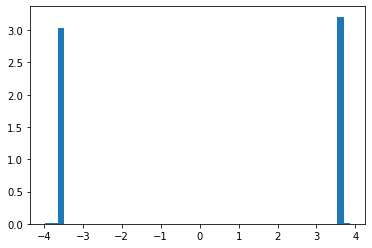

In [104]:
plt.hist(predicted_mean,density=1, bins=bins_mean)
# plt.hist(predicted_var,density=1, bins=bins_var)

plt.show()

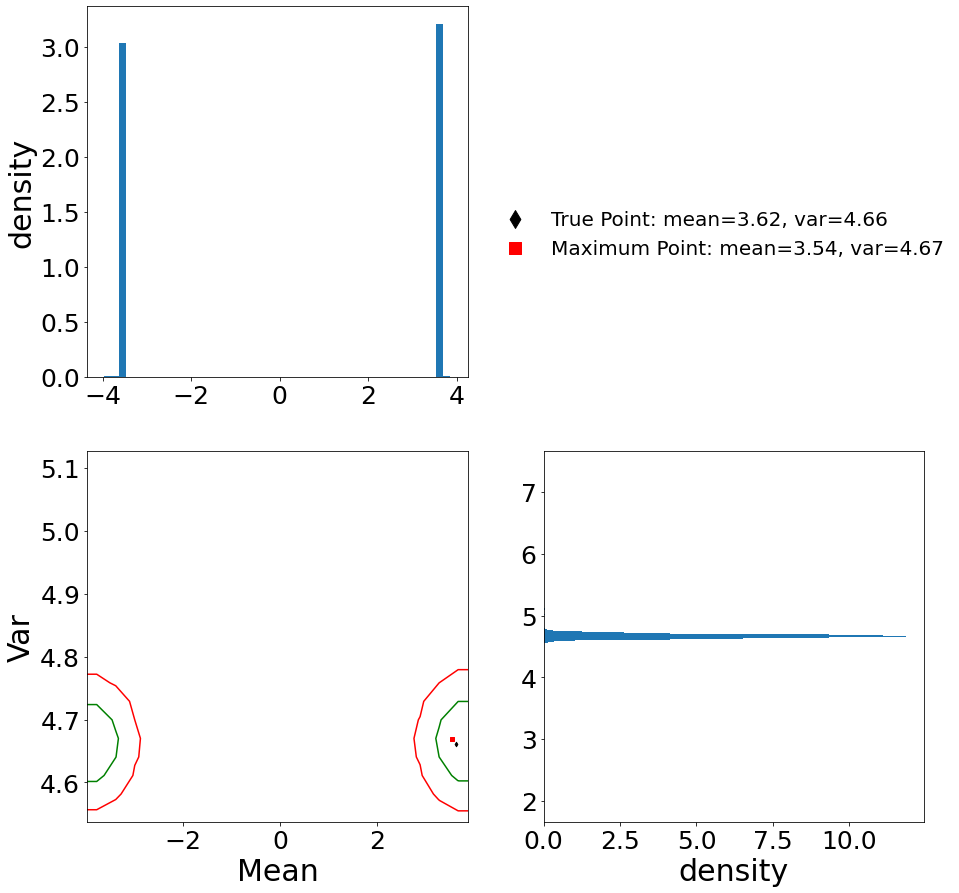

CPU times: user 495 ms, sys: 17.7 ms, total: 513 ms
Wall time: 511 ms


In [105]:
%%time

fig, ax = plt.subplots(1,1, figsize=(15,15))

#=========================== Upper Left Corner
plot_axis = plt.subplot(2,2,1)
"""
ML
"""
plot_axis.hist(predicted_mean, density=1,bins=bins_mean)
# plot_axis.set_xlim((true_mean-3,true_mean+3))
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
plot_axis.set_ylabel(r'density', fontsize=30)
#===========================




#=========================== Down Right Corner
plot_axis = plt.subplot(2,2,4)
"""
ML
"""
plot_axis.hist(predicted_var,orientation="horizontal",density=1, bins=bins_var)
plot_axis.set_ylim((true_var-3,true_var+3))
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
plot_axis.set_xlabel(r'density', fontsize=30)
#===========================


#=========================== Down Left Corner
plot_axis = plt.subplot(2,2,3)

# """
# ML (Poisson)
# """
corner.hist2d(predicted_mean, predicted_var,
                    levels=(0.68,),
                    scale_hist=True,
                    plot_datapoints=False,
                    color='green',
                    labels= ["mean", "var"],
#                     range=[[true_mean-0.2,true_mean+0.2], [true_var-0.2,true_var+0.2]],
                    plot_contours = True,
                    plot_density = False,
                    fontsize=30,
                    label_kwargs={"fontsize": 30},
                    smooth=True
                   )

corner.hist2d(predicted_mean, predicted_var,
                    levels=(0.95,),
                    scale_hist=True,
                    plot_datapoints=False,
                    color='red',
                    labels= ["mean", "var"],
#                     range=[[true_mean-0.2,true_mean+0.2], [true_var-0.2,true_var+0.2]],
                    plot_contours = True,
                    plot_density = False,
                    fontsize=30,
                    label_kwargs={"fontsize": 30},
                    smooth=True
                   )


plot_axis.scatter(true_mean, true_var, marker="d", c="k", s=10, label = "True Point: mean=%.2f, var=%.2f" %(true_mean, true_var))

plot_axis.scatter(xedges[max_poi[1]],yedges[max_poi[0]+1], marker="s", c="r", s=10, label = "Maximum Point: mean=%.2f, var=%.2f" %(xedges[max_poi[1]][0], yedges[max_poi[0]+1][0]))

    


plot_axis.set_xlabel("Mean", fontsize=30)
plot_axis.set_ylabel("Var", fontsize=30)
# plot_axis.set_xlim((true_mean-3,true_mean+3))
# plot_axis.set_ylim((true_var-3,true_var+3))
    
    
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
#===========================
                              
    

#=========================== Whole Figure Setting

plt.legend(bbox_to_anchor=(2.3, 1.7), ncol=1,fontsize=20, markerscale=4, edgecolor = "w",fancybox=False, framealpha=0)
plt.show()